# Fitting Maxima

In this notebook I am going to use the Gaussian process (see nb) to see if I can accurately model the solar cycle maxima.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('Data/maxima_poly1.csv') # importing maxima data for SVG polyorder = 1
X = ((df.Year).values).reshape(-1,1)
y = (df.Solar_Cycle_Maxima).values 
yerr = np.zeros(len(X)) 

In [3]:
rng = [np.random.RandomState(1), np.random.RandomState(2), np.random.RandomState(3)] # testing 3 different samples
training_indices = [rng[i].choice(np.arange(y.size), size=12, replace=False) for i in range(len(rng))] 

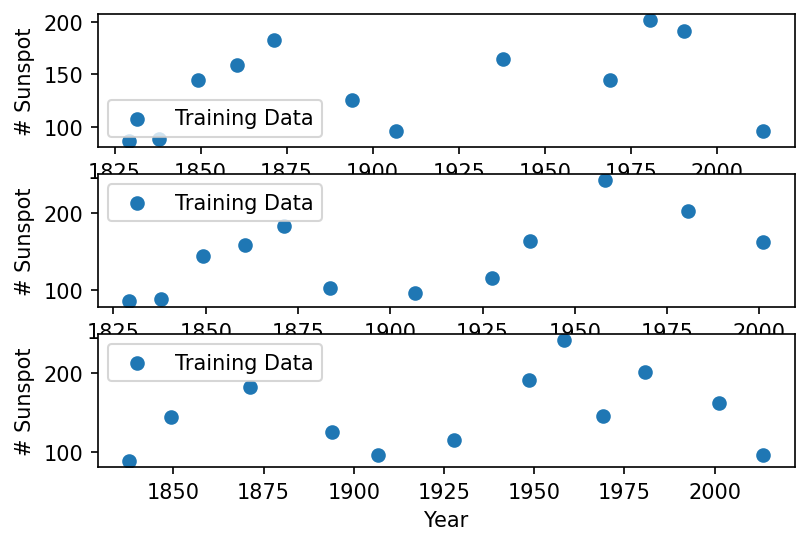

In [4]:
X_train = [X[training_indices[i]] for i in range(len(rng))] # x & y values of random indicies
y_train = [y[training_indices[i]] for i in range(len(rng))]

fig, ax = plt.subplots(len(rng), dpi=150)
for i in range(len(rng)):
    ax[i].scatter(X_train[i], y_train[i], label='Training Data')
    ax[i].set_xlabel('Year')
    ax[i].set_ylabel("# Sunspot")
    ax[i].legend();

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

/Users/davies/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/davies/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 99. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/davies/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 101. Increasing the bound and calling fit again may find a better value.

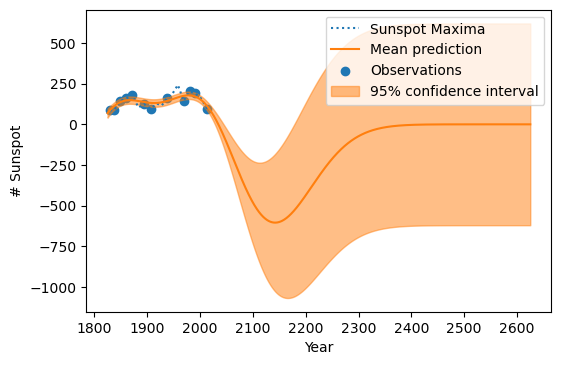

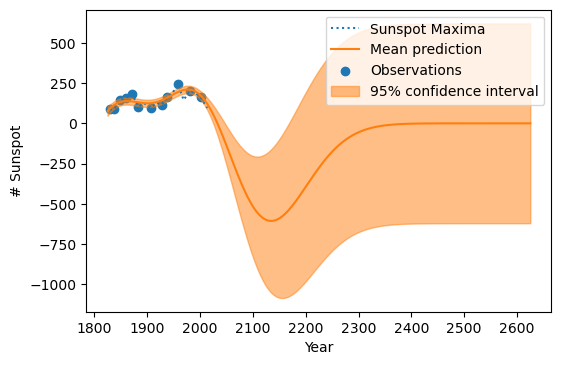

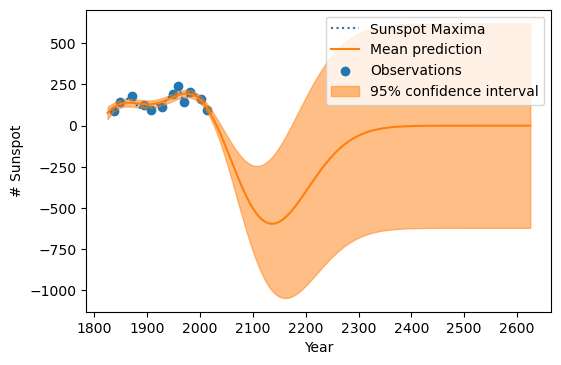

In [9]:
l = 100
ldelta = 1
w = 100
wdelta = 1
X_new = np.linspace(1825, 2625, 1000).reshape(-1,1)
for i in range(len(rng)):
    kernel = 100 * RBF(length_scale=l, length_scale_bounds=(l-ldelta, l-ldelta)) \
                + WhiteKernel(noise_level=w, noise_level_bounds=(w-wdelta, w+wdelta))
    
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gaussian_process.fit(X_train[i], y_train[i])
    gaussian_process.kernel_
    mean_prediction, std_prediction = gaussian_process.predict(X_new, return_std=True)
    fig, ax = plt.subplots(dpi=100)
    ax.plot(X, y, label=r"Sunspot Maxima", linestyle='dotted') 
    ax.scatter(X_train[i], y_train[i], label="Observations") # training data
    ax.plot(X_new, mean_prediction, label="Mean prediction") # gp prediction
    ax.fill_between(
        X_new.ravel(),
        (mean_prediction - 1.96 * std_prediction), # 95% confidence interval
        (mean_prediction + 1.96 * std_prediction),
        alpha=0.5, color='tab:orange',
        label=r"95% confidence interval",
    )                                                
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel("# Sunspot");

#### Comment on plot:
From the plot above we can see that the GP makes a good effort to model the sunspot maxima, but unfortunately it doesnt do a *good enough* job. The 95% intervals are far too large, and the mean predictions don't follow the actual trend as well as they should.